In [1]:
import numpy as np
from bci_plot.utils import data_util
import matplotlib.pyplot as plt
import matplotlib as mpl
import pathlib
import argparse
import ast
import re

from plot_util import get_readme, get_target_pos_dia

/home2/sangjoon/miniconda3/envs/eeg-decode/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_copilot_status(data_path):
    """ returns the copilot status. 1.0: no copilot, 0.0: copilot ON """
    readme = get_readme(data_path)
    copilot = float(readme['kfCopilotAlpha (1.0: no copilot)'])
    return copilot

### Refactored

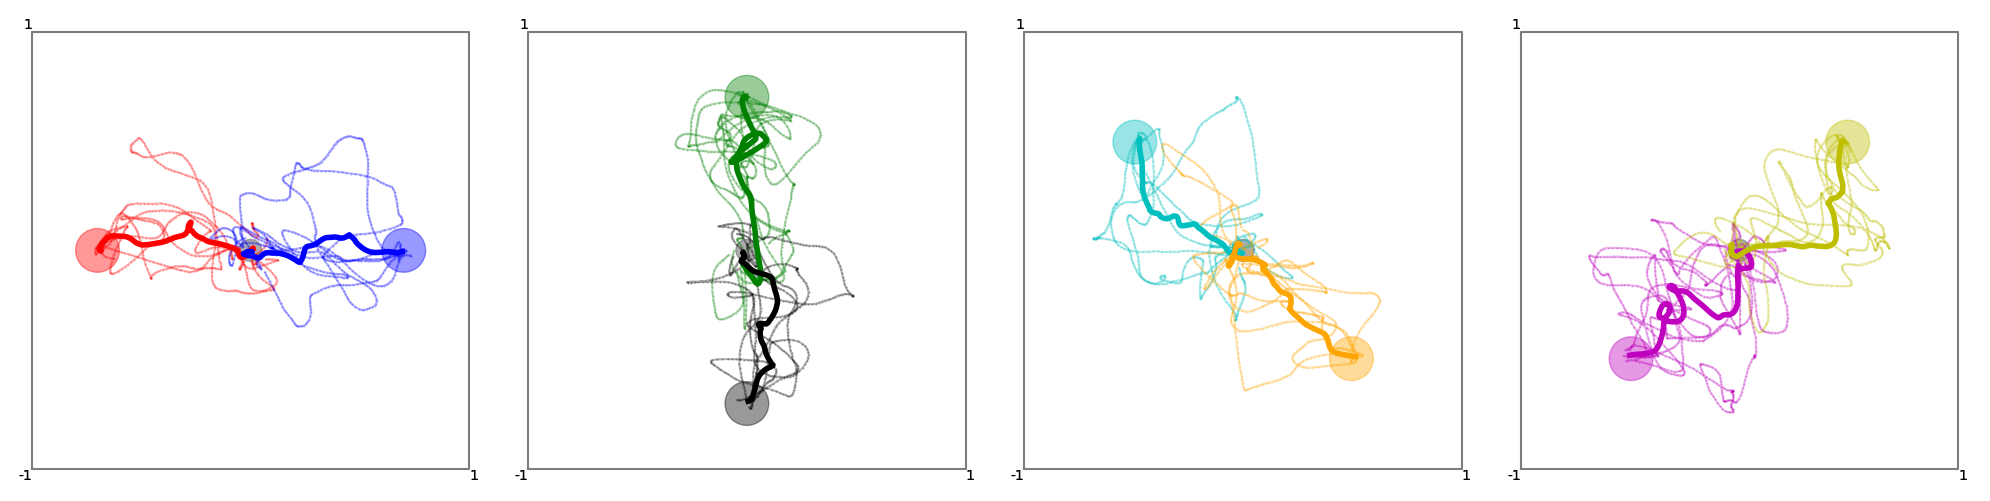

In [3]:
def createPlotTitle(data_path, session, suffix=''):
    """ create title for plot """
    copilot_info = get_copilot_status(data_path) #kfCopilotAlpha (1.0: no copilot)
    hasCopilot = '_copilot_ON' if copilot_info == 0.0 else ''

    plotTitle = f'../figs/trajectory_plots/{session}{hasCopilot}{suffix}.pdf'
    return plotTitle


def getTrajectories(session, onlySuccessful=False):

    datadir = pathlib.Path('/data/raspy/')
    data_path = datadir / session

    # read the task data
    task_data = data_util.load_data(data_path / 'task.bin')
    game_state = task_data['game_state'].flatten().copy()
    state_task = task_data['state_task'].flatten().copy() # tells about the game state i.e. where the target is
    state_task[task_data['numCompletedBlocks'].flatten() < 0] = 99 # for the starting few calibration trials


    # start and end indices for trials. reading the index at which the game state changes 
    start_inds = np.nonzero(state_task[1:None] != state_task[0:-1])[0][1:None] + 1
    end_inds = np.hstack([start_inds[1:None], [len(state_task)+1]])

    # Dictionary to store trajectories for each target
    trajectories = {i: [] for i in range(9) if i != 4}
    for start, end in zip(start_inds, end_inds):
        xy = task_data['decoded_pos'][start:end]
        target = state_task[start]
        if target != 99:
            if onlySuccessful:
                if chr(game_state[end-1]) == 'H':
                    trajectories[target].append(xy[1:])
                else: # missed
                    pass
            else:
                trajectories[target].append(xy[1:])
    
    return trajectories

def colorPallete():
    """ get color information """
    # 4 is missing from the state_task. 0,1,2,3,5,6,7,8 left, right, up, down, lu, ld, ru, rd
    colors = {0:'r', 1:'b', 2:'g', 3:'k', 5:'c', 6:'m', 7:'y', 8:'orange'}
    subplot_map = {0:0, 1:0, 2:1, 3:1, 5:2, 6:3, 7:3, 8:2}
    circle_map = {0:0, 1:0, 2:1, 3:1, 4:2, 5:3, 6:3, 7:2}
    colors_map = {0:0, 1:1, 2:2, 3:3, 4:5, 5:6, 6:7, 7:8}
    return colors, subplot_map, circle_map, colors_map


def addCursorAndTargetToPlot(axesFromSubplots, target_pos, target_dia):
    """ add cursor and target to 4 targets """

    colors, subplot_map, circle_map, colors_map = colorPallete()
    axes = axesFromSubplots
    
    for i in range(8):
        # plt.subplot(2,4,i+1)
        
        circle = plt.Circle(target_pos[i], target_dia/2.0, color=colors[colors_map[i]], alpha=0.4, zorder=-4)
        cursor = plt.Circle((0.0, 0.0), 0.05, color='gray', alpha=0.4, zorder=-4)
        ax = axes[circle_map[i]]
        # ax = plt.gca()
        ax.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], 'k', alpha = 0.3)
        ax.add_patch(circle)
        ax.add_patch(cursor)
        ax.set_aspect('equal')
        # Annotate the end points
        ax.text(-1, -1, '-1', fontsize=10, ha='right', va='top')
        ax.text(-1, 1, '1', fontsize=10, ha='right', va='bottom')
        ax.text(1, -1, '1', fontsize=10, ha='left', va='top')

def addTrajectoryToPlot(axes, trajectories, alpha=1):

    colors, subplot_map, circle_map, colors_map = colorPallete()

    for target, relevantTrajectory in trajectories.items():
        for xy in relevantTrajectory:
            c = colors[target]
            ax = axes[subplot_map[target]]
            ax.plot(xy[:,0], xy[:,1], '.-', c=c, ms=1, alpha=alpha)
            ax.set_ylim(-1.1, 1.1)
            ax.set_xlim(-1.1, 1.1)
            ax.axis('off')

def addAverageTrajectoryToPlot(axes, trajectories):
    """ plot Average Trajectory """  

    colors, subplot_map, circle_map, colors_map = colorPallete()

    # Plot average trajectories
    for target, traj_list in trajectories.items():
        if traj_list:  # Check if there are trajectories for this target
            interp_x = []
            interp_y = []
            for traj in traj_list:
                interp_x.append(np.interp(np.linspace(0, 1, 100), np.linspace(0, 1, len(traj)), traj[:, 0]))
                interp_y.append(np.interp(np.linspace(0, 1, 100), np.linspace(0, 1, len(traj)), traj[:, 1]))
            
            avg_traj_x = np.mean(interp_x, axis=0)
            avg_traj_y = np.mean(interp_y, axis=0)
            ax = axes[subplot_map[target]]
            c = colors[target]
            ax.plot(avg_traj_x, avg_traj_y, c=c, linewidth=4, label='Avg Trajectory')


def plotTrajectory(session, averagePlottingOn=False):
    """
    plot trajectory, 
    returns title of the plot
    """

    datadir = pathlib.Path('/data/raspy/')
    data_path = datadir / session

    plotTransparency = 0.3 if averagePlottingOn else 1
    suffix = '_average' if averagePlottingOn else ''
    plotTitle = createPlotTitle(data_path, session, suffix)

    # grabTrajectory
    trajectories = getTrajectories(session)

    # Create single plot with 4 subplots
    fig, axes = plt.subplots(1,4,figsize=(20, 10))
    axes = axes.flatten() # Flatten the axes array to iterate over it easily

    # add trajectory to plot
    addTrajectoryToPlot(axes, trajectories, alpha=plotTransparency)

    # add average trajectory to plot
    if averagePlottingOn:
        addAverageTrajectoryToPlot(axes, trajectories)

    # read the target position and diameter from the readme.txt
    target_pos, target_dia = get_target_pos_dia(data_path)
    addCursorAndTargetToPlot(axes, target_pos, target_dia)

    # fig.suptitle(f'{session} {copilot} target dia {target_dia}', fontsize = 16, y= 0.75)
    mpl.rcParams['pdf.fonttype'] = 42
    plt.tight_layout()
    plt.savefig(plotTitle, bbox_inches='tight')

plotTrajectory(session = '2024-02-14_H1_CL_CP_2', averagePlottingOn=True)


### Plot Trajectory

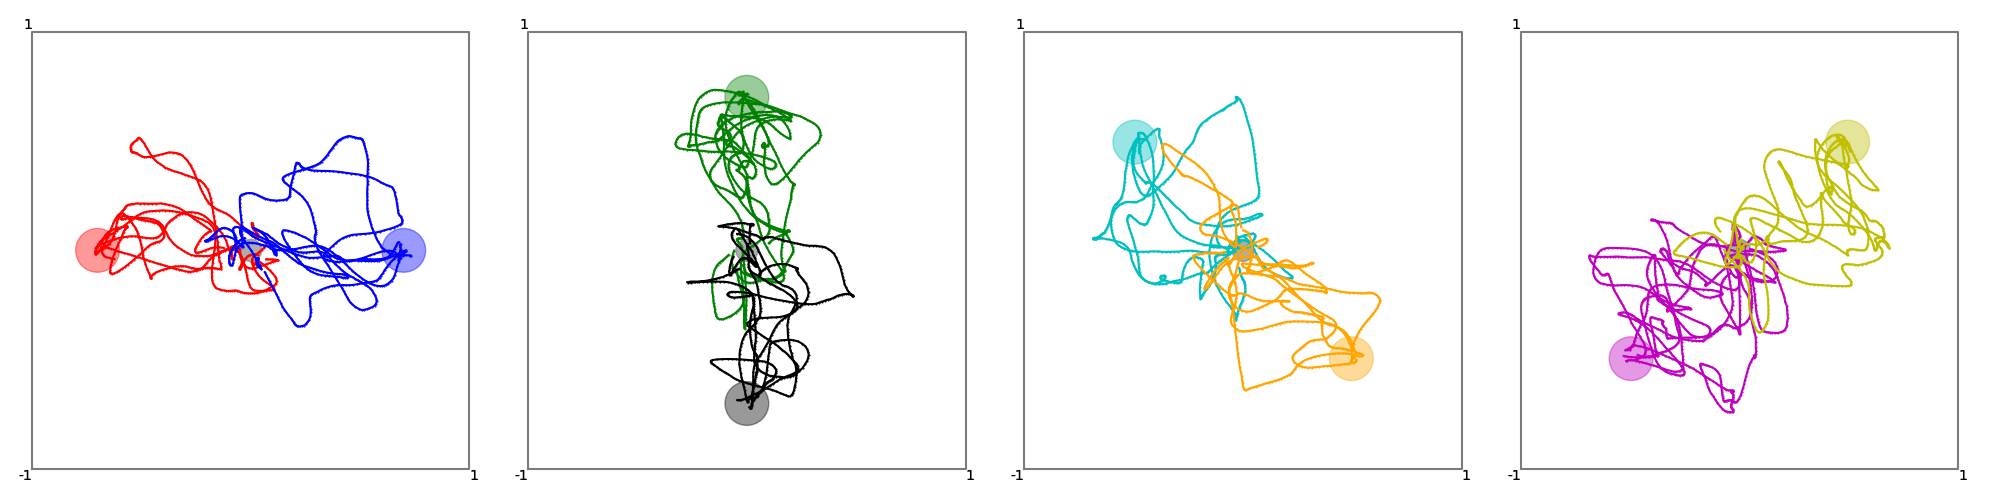

In [6]:
plotTrajectory(session = '2024-02-14_H1_CL_CP_2', averagePlottingOn=False)

### Plotting average trajectory

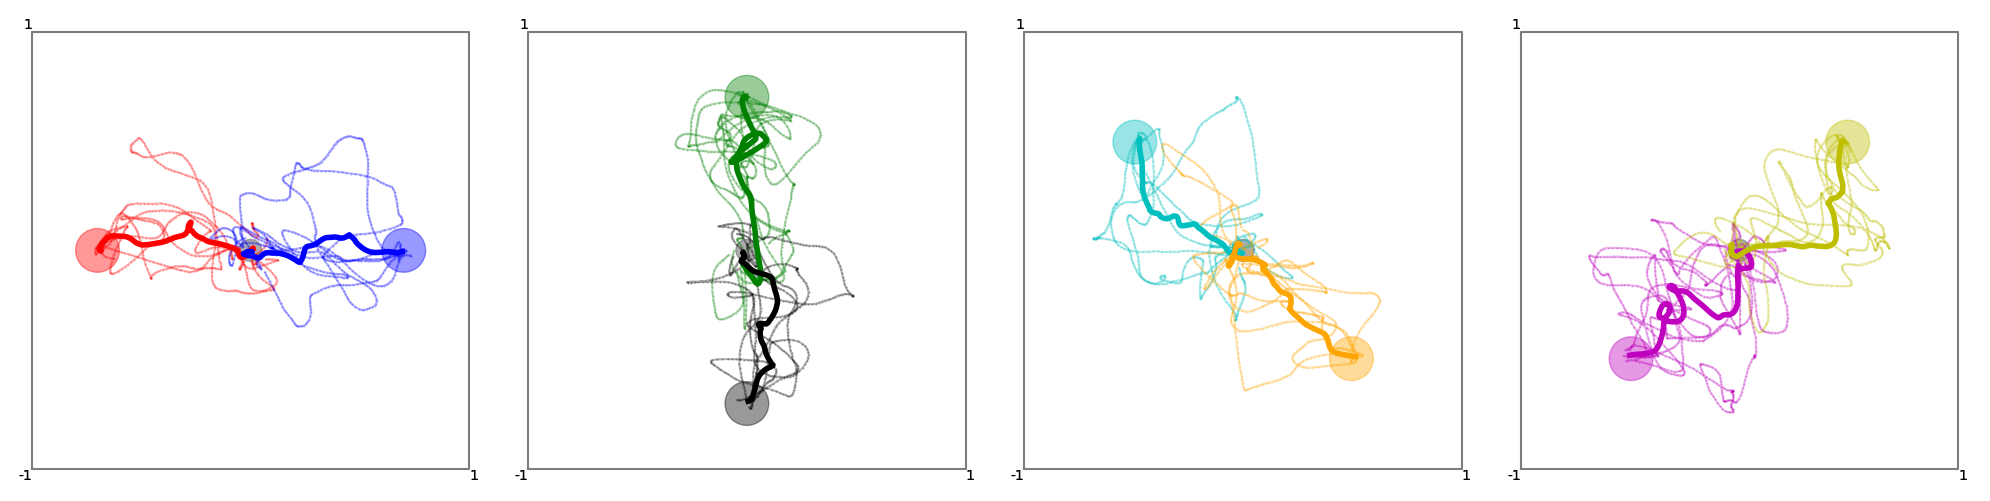

In [7]:
plotTrajectory(session = '2024-02-14_H1_CL_CP_2', averagePlottingOn=True)

In [14]:
# sessions = [
#     '2024-02-14_H1_CL_CP_1', # H1 no copilot
#     '2024-02-14_H1_CL_CP_2', # H1 with copilot
#     '2024-03-18_S2_CL_3', # S2 no copilot 
#     '2024-03-18_S2_CL_4', # S2 with copilot
# ]

# for session in sessions:
#     plotTrajectory(session, averagePlottingOn=False)

### Plot only the average trajectory plot on a single plot

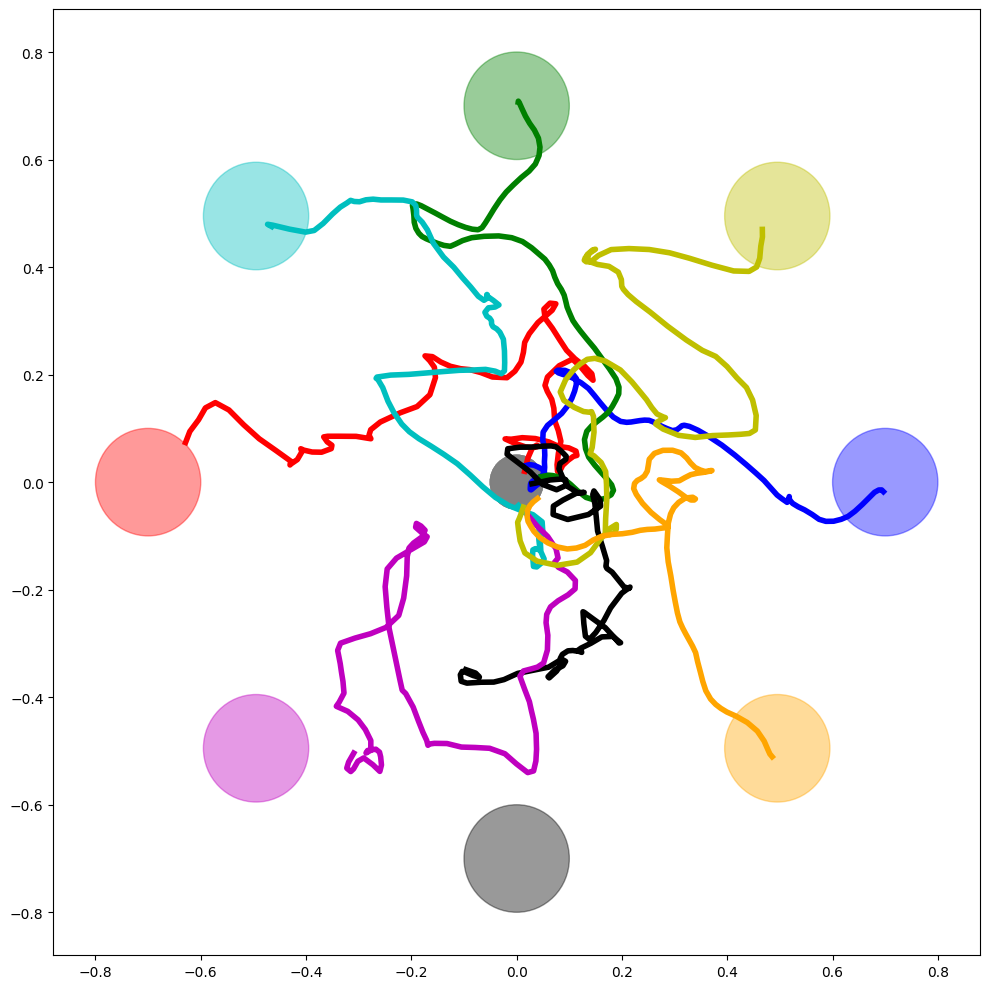

In [8]:
def addCursorAndTargetToSinglePlot(ax, target_pos, target_dia):
    """ add cursor and target to single plot: ax """

    colors, subplot_map, circle_map, colors_map = colorPallete()

    for i in range(8):
        # plt.subplot(2,4,i+1)

        circle = plt.Circle(target_pos[i], target_dia/2.0, color=colors[colors_map[i]], alpha=0.4, zorder=-4)
        cursor = plt.Circle((0.0, 0.0), 0.05, color='gray', alpha=0.4, zorder=-4)
        # ax = axes[circle_map[i]]
        # ax = plt.gca()
        
        ax.add_patch(circle)
        ax.add_patch(cursor)

def addAverageTrajectoryToSinglePlot(ax, trajectories):

    colors, subplot_map, circle_map, colors_map = colorPallete()
    for target, traj_list in trajectories.items():
        if traj_list:  # Check if there are trajectories for this target
            interp_x = []
            interp_y = []
            for traj in traj_list:
                interp_x.append(np.interp(np.linspace(0, 1, 100), np.linspace(0, 1, len(traj)), traj[:, 0]))
                interp_y.append(np.interp(np.linspace(0, 1, 100), np.linspace(0, 1, len(traj)), traj[:, 1]))
            
            avg_traj_x = np.mean(interp_x, axis=0)
            avg_traj_y = np.mean(interp_y, axis=0)
            # ax = axes[subplot_map[target]]
            c = colors[target]
            ax.plot(avg_traj_x, avg_traj_y, c=c, linewidth=4, label='Avg Trajectory')

def plotSingleAvgTrajectory(session, onlySuccessful=False):
    """
    plot trajectory, 
    returns title of the plot
    """

    datadir = pathlib.Path('/data/raspy/')
    data_path = datadir / session

    suffix = '_Average_AllTargets'
    if onlySuccessful:
        suffix += '_OnlySuccessful'
    plotTitle = createPlotTitle(data_path, session, suffix)

    # grabTrajectory
    trajectories = getTrajectories(session, onlySuccessful)

    # Create single plot with 4 subplots
    fig, ax = plt.subplots(figsize=(10, 10))

    # add average trajectory to plot
    addAverageTrajectoryToSinglePlot(ax, trajectories)

    # read the target position and diameter from the readme.txt
    target_pos, target_dia = get_target_pos_dia(data_path)
    addCursorAndTargetToSinglePlot(ax, target_pos, target_dia)

    # fig.suptitle(f'{session} {copilot} target dia {target_dia}', fontsize = 16, y= 0.75)
    mpl.rcParams['pdf.fonttype'] = 42
    plt.tight_layout()
    plt.savefig(plotTitle, bbox_inches='tight')


plotSingleAvgTrajectory('2024-03-18_S2_CL_4', onlySuccessful=False)


### plot average trajectory for all sessions

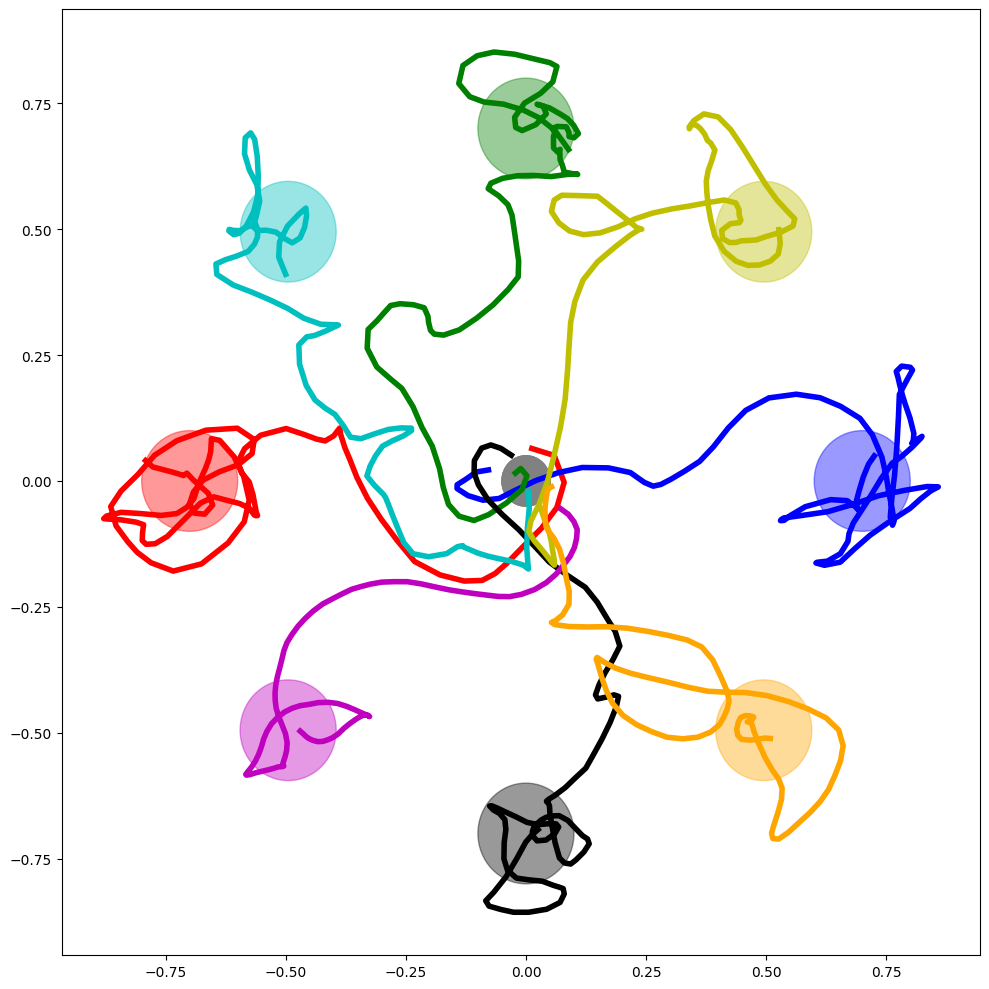

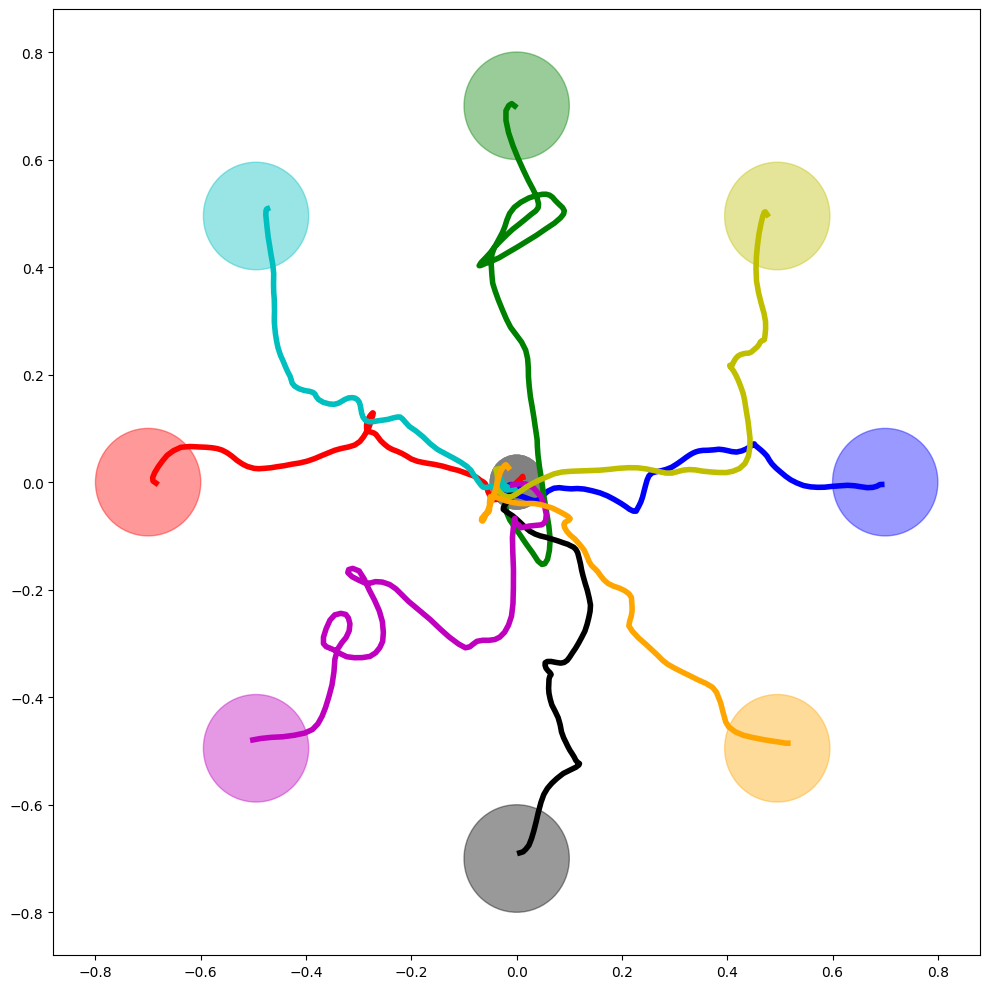

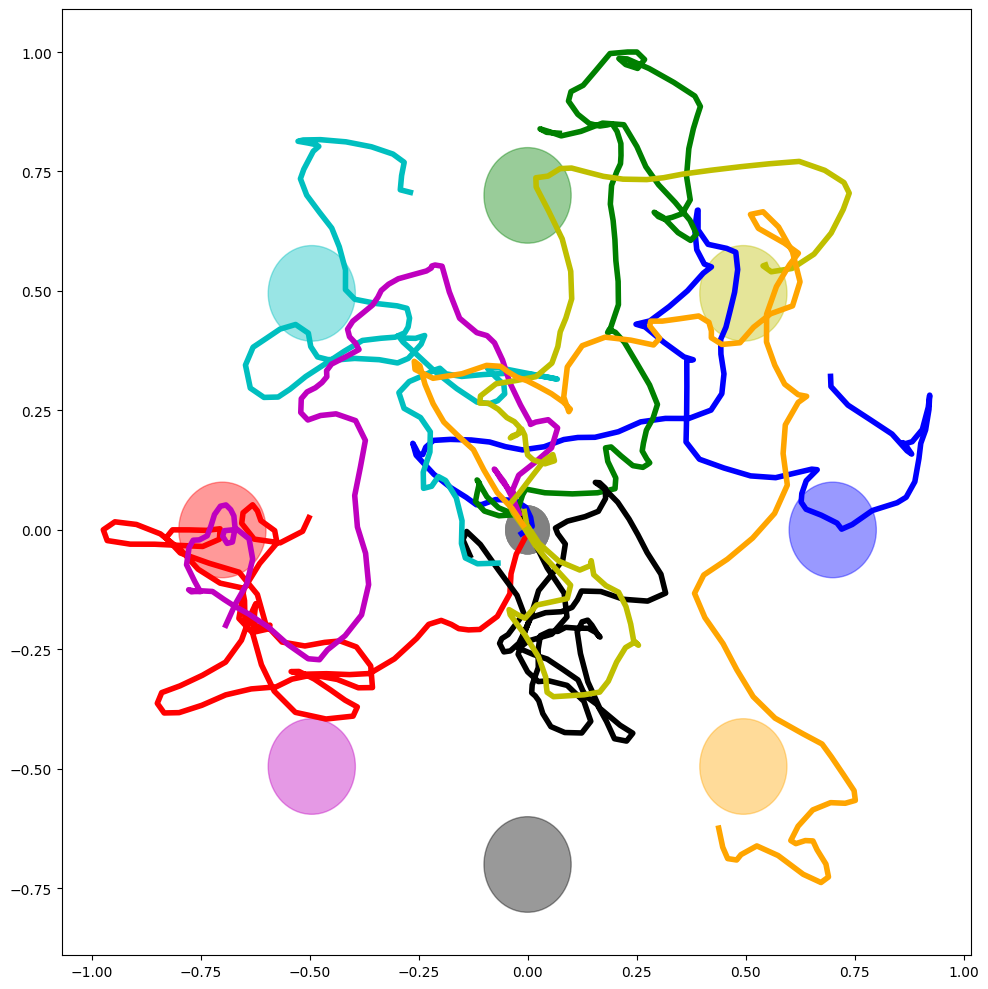

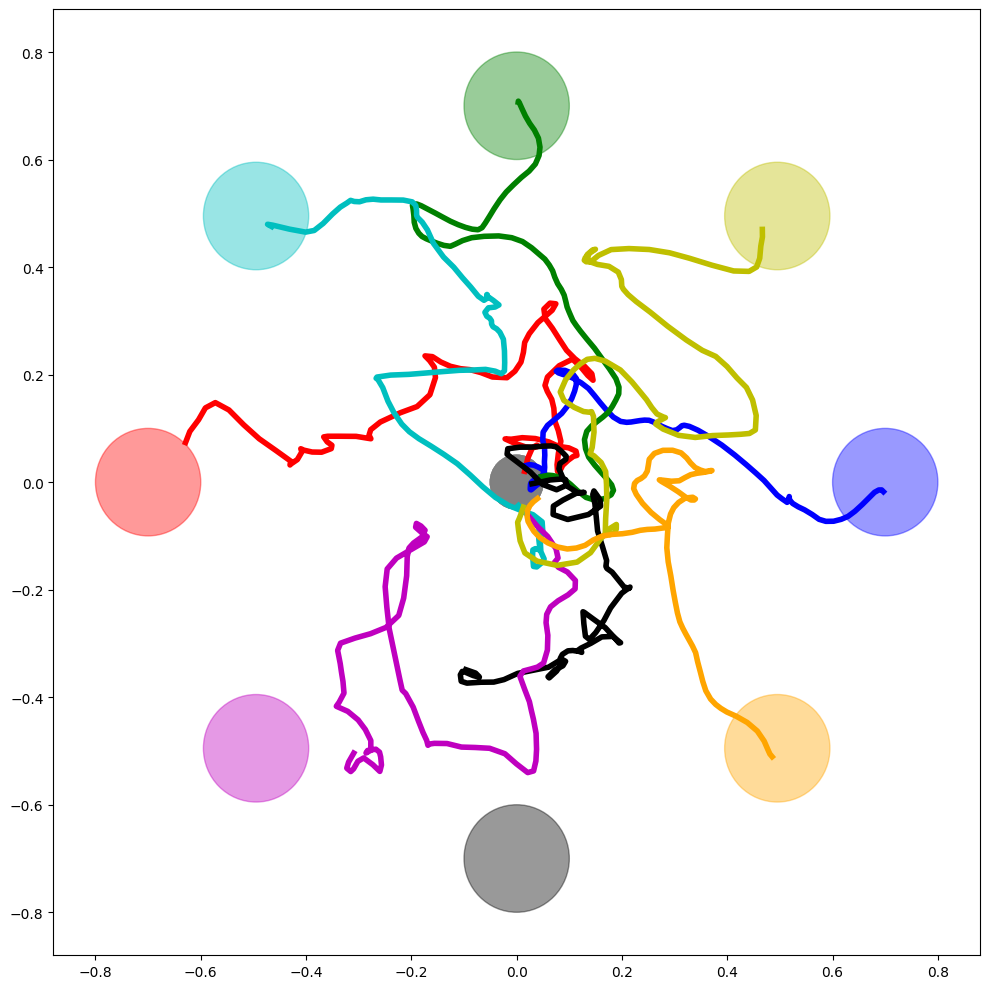

In [9]:
sessions = [
    '2024-02-14_H1_CL_CP_1', # H1 no copilot
    '2024-02-14_H1_CL_CP_2', # H1 with copilot
    '2024-03-18_S2_CL_3', # S2 no copilot 
    '2024-03-18_S2_CL_4', # S2 with copilot
]

for session in sessions:
    plotSingleAvgTrajectory(session, onlySuccessful=False)

### plot average trajectory for all sessions (only Successful)

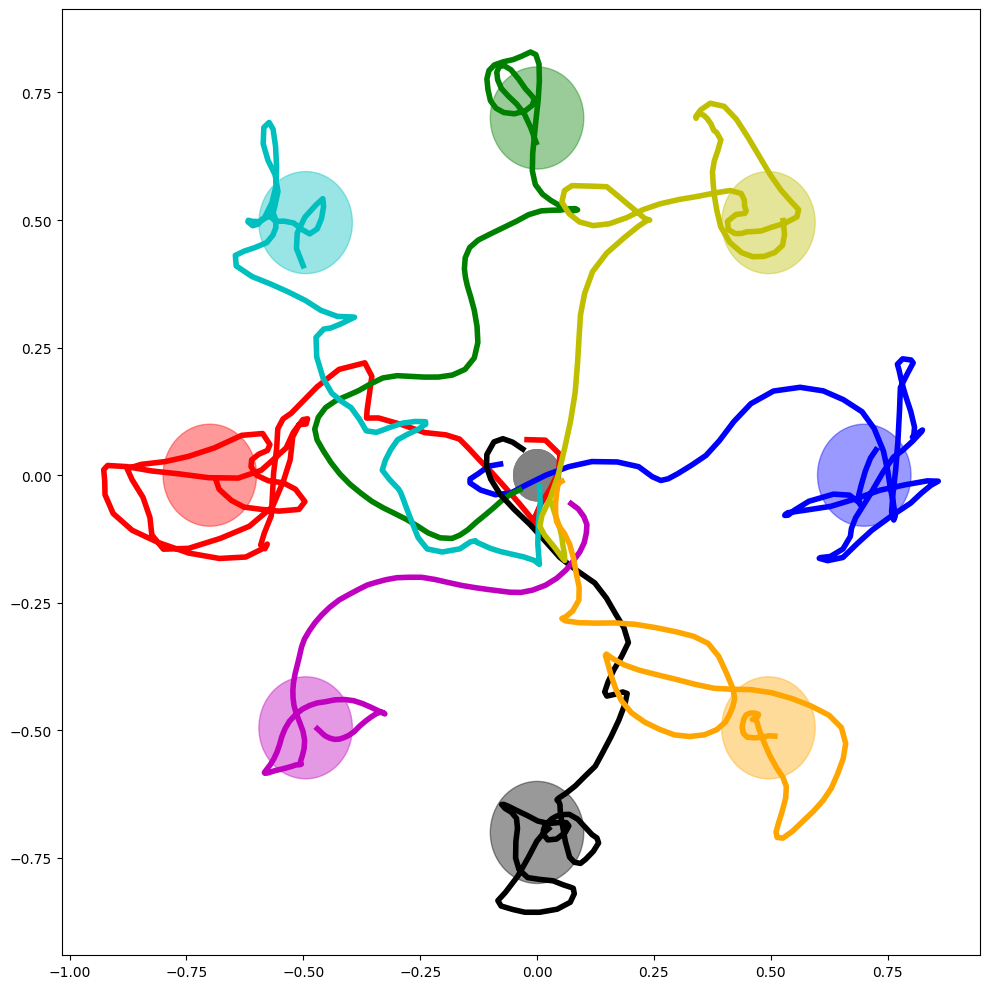

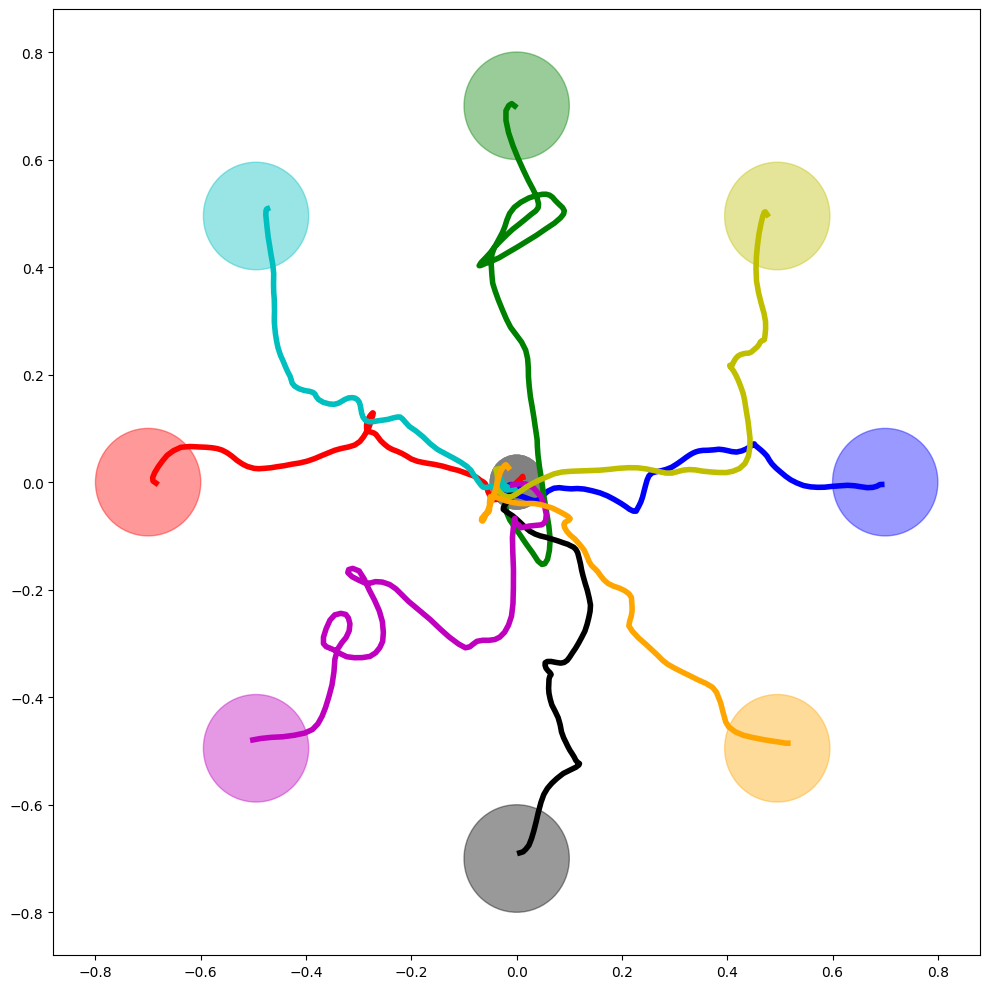

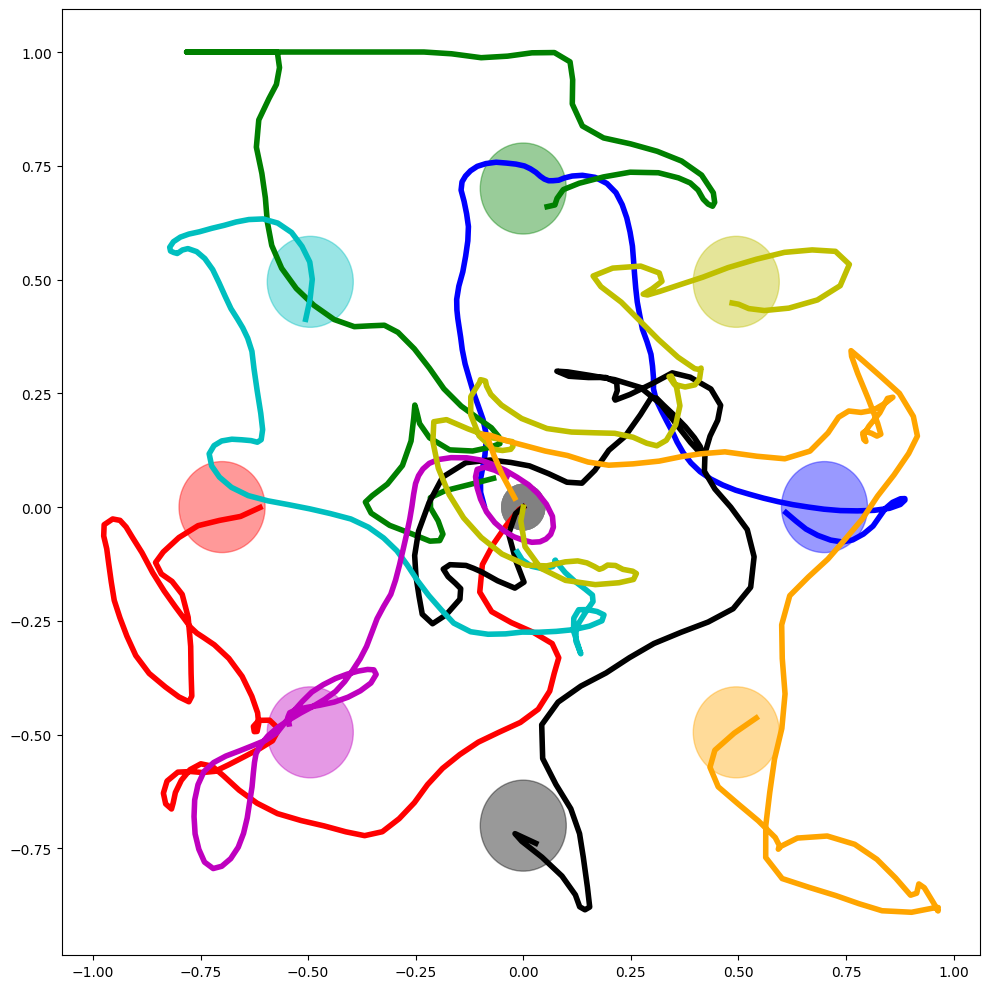

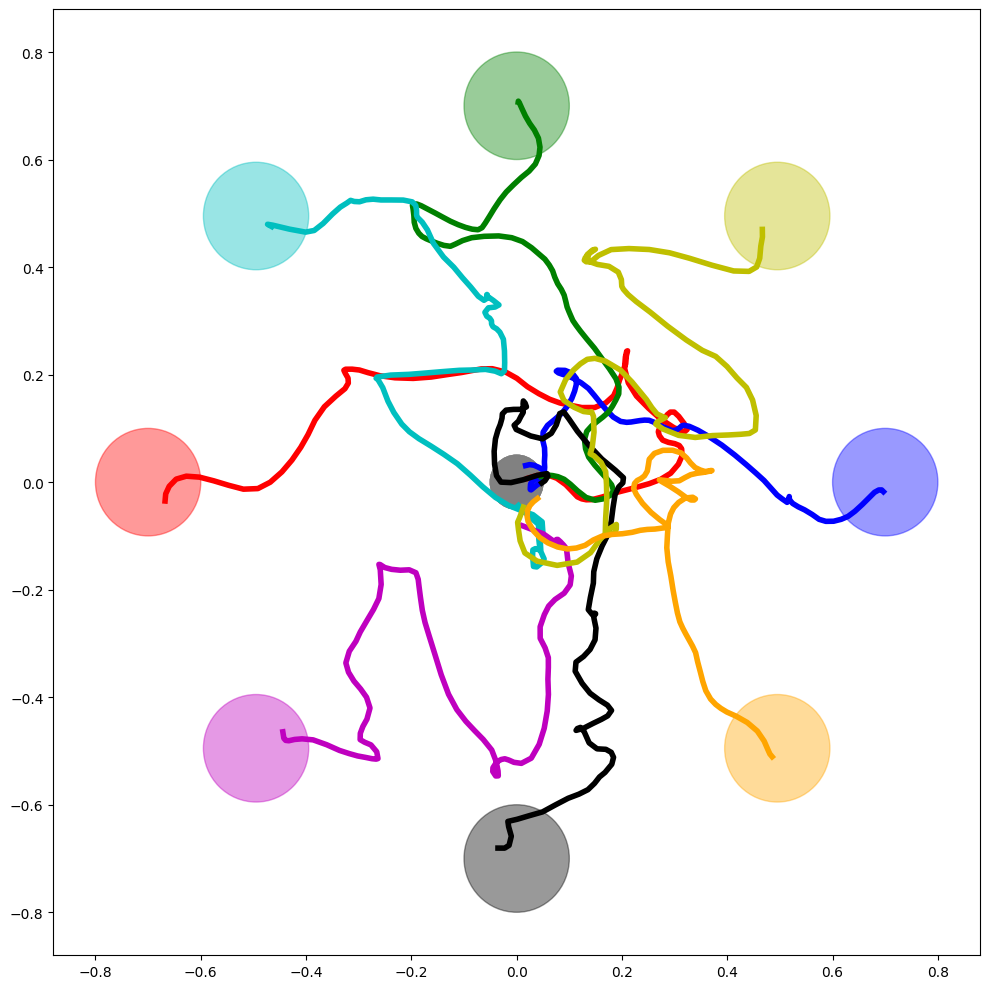

In [10]:
sessions = [
    '2024-02-14_H1_CL_CP_1', # H1 no copilot
    '2024-02-14_H1_CL_CP_2', # H1 with copilot
    '2024-03-18_S2_CL_3', # S2 no copilot 
    '2024-03-18_S2_CL_4', # S2 with copilot
]

for session in sessions:
    plotSingleAvgTrajectory(session, onlySuccessful=True)

In [26]:
sessions = [
    '2024-02-14_H1_CL_CP_1', # H1 no copilot
    '2024-02-14_H1_CL_CP_2', # H1 with copilot
    '2024-03-18_S2_CL_3', # S2 no copilot 
    '2024-03-18_S2_CL_4', # S2 with copilot
]

print([0] * 8)
for session in sessions:
    trajectories = getTrajectories(session, onlySuccessful=True)
    tLength = [0] * 8
    for i, (target, t) in enumerate(trajectories.items()):
        tLength[i] = len(t)
    print(tLength)

[0, 0, 0, 0, 0, 0, 0, 0]
[2, 3, 2, 3, 3, 3, 3, 3]
[6, 6, 6, 6, 6, 6, 6, 6]
[1, 1, 1, 1, 1, 1, 1, 1]
[3, 4, 4, 3, 4, 3, 4, 4]


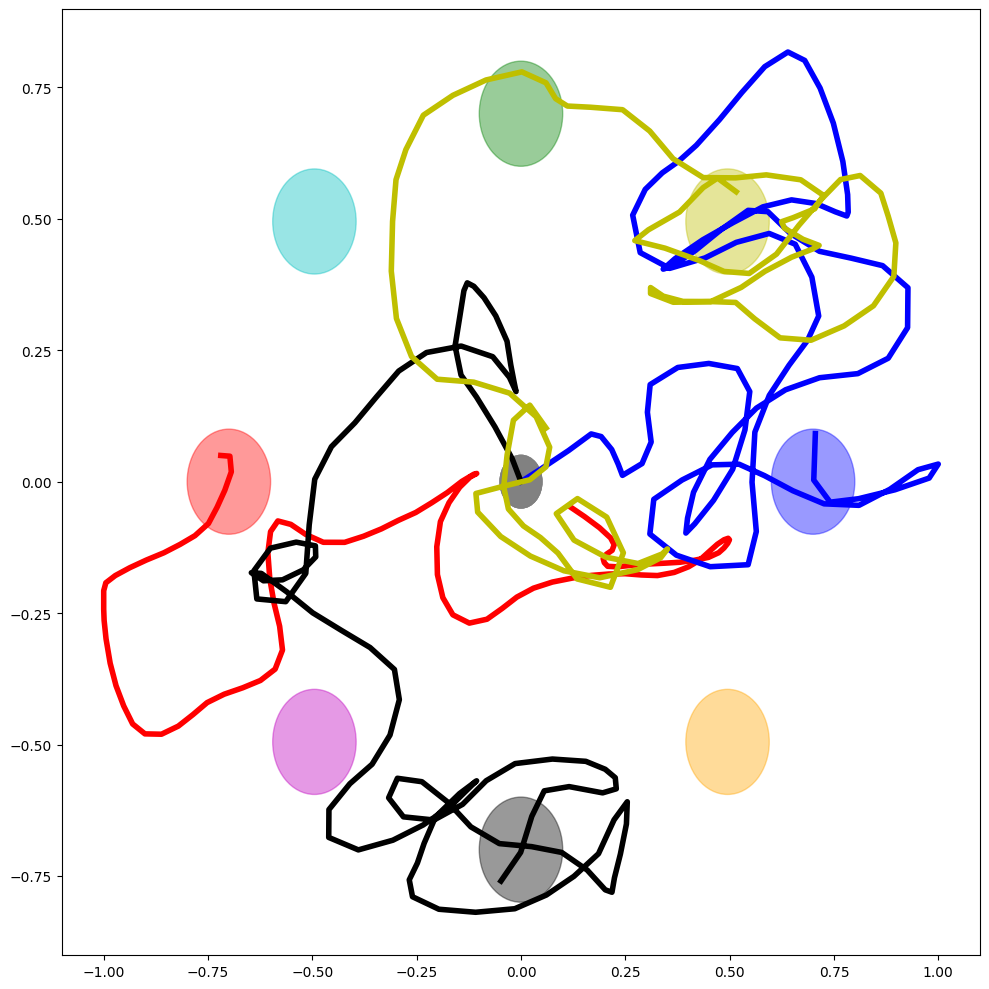

In [27]:
plotSingleAvgTrajectory('2024-03-18_S2_CL_5', onlySuccessful=True)